In [22]:
import os, sys
import numpy as np
import pandas as pd

from config_local import local_config

In [23]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [24]:
train = pd.read_csv(local_config.TRAIN_PROCESS6_CSV)
test  = pd.read_csv(local_config.TEST_PROCESS6_CSV)
testRaw = pd.read_csv(local_config.TEST_CSV, index_col="Id")

In [25]:
y = train['logSP']
X = train.drop(['logSP'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [26]:
alphas = [0.0001, 0.0005, 0.001, 0.002, 0.005,    0.0007, 
    0.0008, 
    0.0009, 
    0.0010, 
    0.0011, 
    0.0012, 
    0.0013, 
    0.0015,0.01]
max_iter = 10000

best_alpha = None
best_rmse = float("inf")

for a in alphas:
    model = Lasso(alpha=a, max_iter=max_iter)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # back to original scale (since y is log-transformed)
    y_pred_real = np.exp(y_pred)
    y_test_real = np.exp(y_test)

    mse = mean_squared_error(y_test_real, y_pred_real)
    rmse = mse ** 0.5

    print(f"alpha={a} -> RMSE={rmse:.2f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = a
print(f"Best alpha: {best_alpha} with RMSE={best_rmse:.2f}")

model = Lasso(alpha=best_alpha, max_iter=max_iter)
model.fit(X_train, y_train)

test_pred = model.predict(test)  
test_pred_real = np.exp(test_pred)


alpha=0.0001 -> RMSE=20357.45
alpha=0.0005 -> RMSE=19670.73
alpha=0.001 -> RMSE=19650.43
alpha=0.002 -> RMSE=20336.73
alpha=0.005 -> RMSE=22110.22
alpha=0.0007 -> RMSE=19619.23
alpha=0.0008 -> RMSE=19623.97
alpha=0.0009 -> RMSE=19633.81
alpha=0.001 -> RMSE=19650.43
alpha=0.0011 -> RMSE=19684.84
alpha=0.0012 -> RMSE=19743.26
alpha=0.0013 -> RMSE=19815.04
alpha=0.0015 -> RMSE=19956.44
alpha=0.01 -> RMSE=23015.37
Best alpha: 0.0007 with RMSE=19619.23


In [27]:
submission = pd.DataFrame({
    "Id": testRaw.index,
    "SalePrice": test_pred_real
})

out_path = os.path.join(local_config.SUBMISSIONS_DIR, "lassoModel.csv")
submission.to_csv(out_path, index=False)

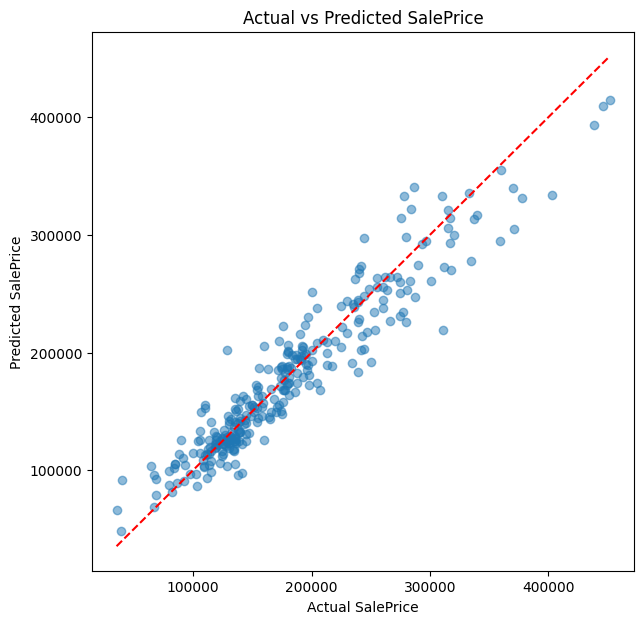

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# If you used log1p:
y_true = np.expm1(y_test)
y_pred = np.expm1(y_pred)

plt.figure(figsize=(7,7))
plt.scatter(y_true, y_pred, alpha=0.5)

# perfect prediction line
line_min = min(y_true.min(), y_pred.min())
line_max = max(y_true.max(), y_pred.max())
plt.plot([line_min, line_max], [line_min, line_max], 'r--')

plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")

plt.show()